# Generative Adversial Networks

This is a guide for creating a Generative Adversial Network (GAN). The guide is meant to cover the basics of GANs and to use as reference in related future work. The guide is heavily influenced by the tutorial found at https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f.

The guide will cover:
1. Data loading.
2. Building the network
3. ..

In [102]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from timeit import default_timer as timer
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Loading

In [38]:
def MNIST_dataset():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
dataset = MNIST_dataset()

# Show Training Images

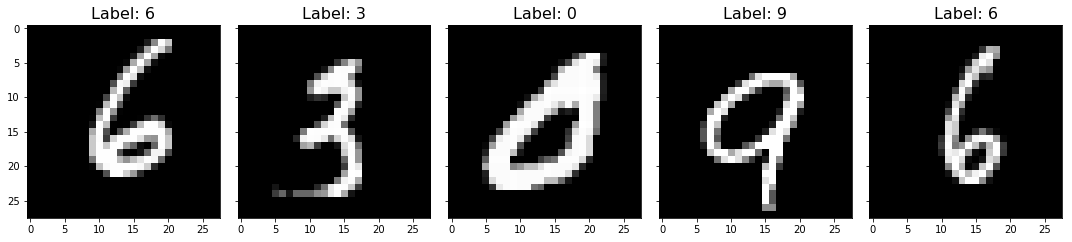

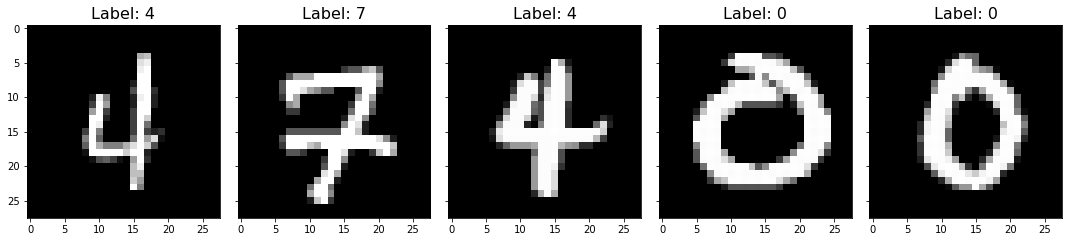

In [39]:
def show_images(dataset):
    """
    Show sample images, their unique name, concentration and pixel intensity.
    
    Args
        dataset: should contain dataset.df and dataset[idx] = sample.
    """
    # random sample 5 samples to plot        
    idx = random.sample(range(1, dataset.train_data.shape[0]), k=5)

    fig, axs = plt.subplots(1, 5, figsize=(15,7), sharey=True)
    
    # plot sample images
    for n, i in enumerate(idx):
        axs[n].imshow(dataset.train_data[i], cmap='gray')
        axs[n].set_title("Label: "+str(dataset.train_labels[i].item()), fontsize=16)
    plt.tight_layout()
    plt.show()
    
for i in range(2):
    show_images(dataset)

# Define the Discriminator Network

In [90]:
class DiscriminatorNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
discriminator = DiscriminatorNet().to(device)
print(discriminator)

DiscriminatorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


## Test Forward Pass of Discriminator

In [91]:
dataset.train_data.shape

torch.Size([60000, 28, 28])

In [92]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [93]:
# test forward pass
x = np.random.uniform(0, 1, size=(10, 28, 28, 1)).astype('float32')
x = torch.autograd.Variable(images_to_vectors(torch.from_numpy(x)))

out = discriminator(x.to(device))
out.shape

torch.Size([10, 1])

# Define the Generator Network

In [94]:
class GeneratorNet(torch.nn.Module):
    
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet().to(device)
print(generator)

GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)


## Test Forward Pass of Generator

In [96]:
# test forward pass
x = np.random.uniform(0, 1, size=(10, 100)).astype('float32')
x = torch.autograd.Variable(torch.from_numpy(x))

out = generator(x.to(device))
out.shape

torch.Size([10, 784])

# Define Noise Function

In [74]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

# Define Optimizer and Loss Function

In [75]:
loss = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Define a Data Loader

In [77]:
BATCH_SIZE = 100

# Create loader with data, so that we can iterate over it
dataloader = torch.utils.data.DataLoader(dataset=dataset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

# Num batches
num_batches = len(dataloader)

In [78]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

# Discriminator Training

In [79]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

# Generator Training

In [80]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error

# Displaying GAN Training Results

In [196]:
def display_training(real_images, fake_images, real_labels, pred_real, pred_fake):
    """"""
    pred_real = pred_real.detach().numpy().flatten()
    pred_fake = pred_fake.detach().numpy().flatten()
    pred_real = ['True' if p >= 0.5 else 'False' for p in pred_real]
    pred_fake = ['True' if p >= 0.5 else 'False' for p in pred_fake]
    real_labels = real_labels.detach().numpy()
    
    fig, axs = plt.subplots(2, 5, figsize=(15,7), sharey=True)
    
    # plot original images
    for i, real_im, fake_im in zip(range(len(real_images)), real_images, fake_images):
        axs[0][i].imshow(real_im.numpy()[0].data, cmap='gray')
        axs[0][i].set_title("Real Label: {}".format(real_labels[i]), fontsize=16)
        axs[1][i].imshow(fake_im.detach().numpy()[0], cmap='gray')
        axs[1][i].set_title("Predicted Real: {}\nPredicted Fake: {}".format(pred_real[i], pred_fake[i]))
    plt.tight_layout()
    plt.show()

# Training Loop

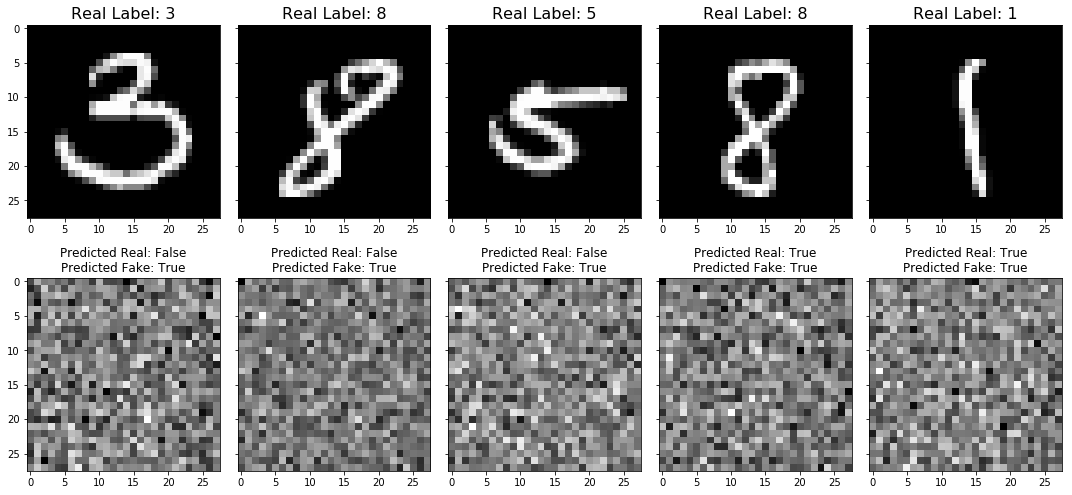

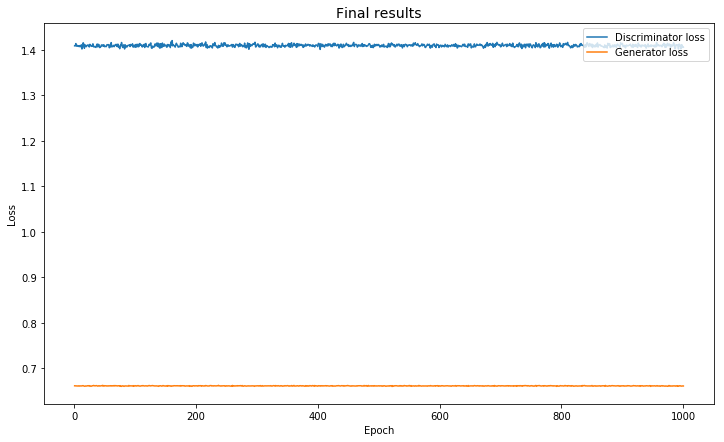

Total Training Time: 2m 48s


In [197]:
# Generate test noise
num_test_samples = 16
test_noise = noise(num_test_samples)

# Total number of epochs to train
num_epochs = 1000
train_results = pd.DataFrame(columns=['epoch', 'd_loss', 'g_loss'])
start_time = timer()

for epoch in range(num_epochs):
    
    epoch_start = timer()
    
    for n_batch, (real_batch, real_labels) in enumerate(dataloader):
        
        N = real_batch.size(0)
        
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        
        # Train Discriminator
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        
        # Train Generator
        g_error = train_generator(g_optimizer, fake_data)
        
        break
        
    results = [epoch+1, d_error, g_error]
    train_results.loc[epoch] = results
    
    # display images
    if epoch % 10 == 0:
        real_data_display = vectors_to_images(real_data[-5:])
        real_labels_display = real_labels[-5:]
        
        fake_data_display = vectors_to_images(fake_data[-5:])
        pred_labels_real = d_pred_real[-5:]
        pred_labels_fake = d_pred_fake[-5:]
        
        display_training(real_data_display, 
                         fake_data_display, 
                         real_labels_display,
                         pred_labels_real, 
                         pred_labels_fake)
        
        
    
        # plot results
        fig = plt.figure(figsize=(12,7))
        plt.title("Running results", fontsize=14)
        plt.ylabel("Loss", fontsize=10)
        plt.xlabel("Epoch", fontsize=10)
        plt.plot(train_results['epoch'], train_results['d_loss'], color='tab:blue', linestyle='-', label='Discriminator loss')
        plt.plot(train_results['epoch'], train_results['g_loss'], color='tab:orange', linestyle='-', label='Generator loss')
        plt.legend(loc='upper right')
        plt.show()

        epoch_time = timer() - epoch_start
        print("Epoch {} Training Time: {:.0f}m {:.0f}s".format(epoch + 1, epoch_time // 60, epoch_time % 60))
        clear_output(wait=True)

# display images
real_data_display = vectors_to_images(real_data[-5:])
real_labels_display = real_labels[-5:]

fake_data_display = vectors_to_images(fake_data[-5:])
pred_labels_real = d_pred_real[-5:]
pred_labels_fake = d_pred_fake[-5:]

display_training(real_data_display, 
                 fake_data_display, 
                 real_labels_display,
                 pred_labels_real, 
                 pred_labels_fake)
    
# plot results
fig = plt.figure(figsize=(12,7))
plt.title("Final results", fontsize=14)
plt.ylabel("Loss", fontsize=10)
plt.xlabel("Epoch", fontsize=10)
plt.plot(train_results['epoch'], train_results['d_loss'], color='tab:blue', linestyle='-', label='Discriminator loss')
plt.plot(train_results['epoch'], train_results['g_loss'], color='tab:orange', linestyle='-', label='Generator loss')
plt.legend(loc='upper right')
plt.show()

total_time = timer() - start_time
print("Total Training Time: {:.0f}m {:.0f}s".format(total_time // 60, total_time % 60))
